### Intro to downstream ipyrad data visualization
All of the modules below are included in the ipyrad conda installation. 

In [1]:
import ipyrad as ip    ## ipyrad
import numpy as np     ## array operations
import h5py            ## to access database file
import toyplot         ## my fav new plotting library
import toyplot.html    ## for saving plots as html

print 'ipyrad', ip.__version__
print 'numpy', np.__version__
print 'h5py', h5py.__version__
print 'toyplot', toyplot.__version__

ipyrad 0.3.25
numpy 1.11.1
h5py 2.6.0
toyplot 0.13.0


### Import the Assembly object
I assembled the data set under three minimum cluster depth settings (6, 10, 20), 
and import their Assembly objects as data1, data2, and data3. 

In [2]:
## import Assembly objects
#data1 = ip.load_json("~/Downloads/pedicularis/cyatho-d6-min4.json")
#data2 = ip.load_json("~/Downloads/pedicularis/cyatho-d10-min4.json")
#data3 = ip.load_json("~/Downloads/pedicularis/cyatho-d20-min4.json")
data = ip.load_json("/home/deren/Downloads/pedicularis/broken.json")

## load the database 
## the default location for the database is in [name]/[name]_consens/
io5 = h5py.File(data.database, 'r')

  loading Assembly: broken
  from saved path: ~/Downloads/pedicularis/broken.json


### The database file
The hdf5 data base is compressed and sometimes quite large. If you moved your JSON file from a remote machine (e.g., HPC cluster) to a local machine you will have to update the `data.database` path to the location of the database file on your local machine. 

In [4]:
print 'location of my database file:\n', data.database
print io5.keys()

location of my database file:
/home/deren/Downloads/pedicularis/broken_outfiles/broken.hdf5
[u'edges', u'filters', u'snps']


### Access arrays
The hdf5 data base contains the following five arrays with the following dimensions.

In [5]:
## This doesn't actually load them into memory, they can be very large.
## It just makes a reference for calling keys more easily

#hcatg = io5["catgs"]    ## depth information (not edge filtered)
#hseqs = io5["seqs"]     ## sequence data (not edge filtered)
hsnps = io5["snps"]      ## snp locations (edge filtered)
hfilt = io5["filters"]   ## locus filters
hedge = io5["edges"]     ## edge filters

## arrays shapes and dtypes
#print hcatg
#print hseqs
print hsnps
print hfilt
print hedge

<HDF5 dataset "snps": shape (84221, 150, 2), type "|b1">
<HDF5 dataset "filters": shape (84221, 6), type "|b1">
<HDF5 dataset "edges": shape (84221, 5), type "<u2">


### A function to filter the SNPs array

In [6]:
def filter_snps(data):
    ## get h5 database
    io5 = h5py.File(data.database, 'r')
    hsnps = io5["snps"]     ## snp locations
    hfilt = io5["filters"]  ## locus filters
    hedge = io5["edges"]    ## edge filters

    ## read in a local copy of the full snps and edge arrays
    snps = hsnps[:]
    edge = hedge[:]

    ## print status
    print "prefilter {}\nshape {} = (nloci, maxlen, [var,pis])"\
          .format(data.name, snps.shape)
    print "total vars = {}".format(snps[:,:,0].sum())

    ## apply edge filters to all loci in the snps array
    for loc in xrange(snps.shape[0]):
        a, b = edge[loc, :2]
        mask = np.invert([i in range(a, b) for i in np.arange(snps.shape[1])])
        snps[loc, mask, :] = 0

    ## get locus filter by summing across all filters
    locfilter = hfilt[:].sum(axis=1).astype(np.bool)

    ## apply filter to snps array
    fsnps = snps[~locfilter, ...]

    ## print new shape and sum
    print "postfilter {}\nshape {} = (nloci, maxlen, [var,pis])"\
          .format(data.name, fsnps.shape)
    print "total vars = {}".format(fsnps[:,:,0].sum())
    
    ## clean up big objects
    del snps
    del edge
    
    ## return what we want
    return fsnps

In [7]:
def filter_snps(data):
    ## get h5 database
    io5 = h5py.File(data.database, 'r')
    hsnps = io5["snps"]     ## snp locations
    hfilt = io5["filters"]  ## locus filters
    #hedge = io5["edges"]    ## edge filters

    ## read in a local copy of the full snps and edge arrays
    snps = hsnps[:]
    #edge = hedge[:]

    ## get locus filter by summing across all filters
    locfilter = hfilt[:].sum(axis=1).astype(np.bool)

    ## apply filter to snps array
    fsnps = snps[~locfilter, ...]

    ## clean up big objects
    del snps
    
    ## return what we want
    return fsnps

In [10]:
## apply filter to each data set
fsnps = filter_snps(data)

In [11]:
a = np.arange(0, 40)#.reshape(10,4)
b = np.arange(10, 50)#.reshape(10, 4)
#np.concatenate((a,b), axis=1)
np.array([a,b]).max(axis=0)


array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49])

### The snps array

In [12]:
## the last dimension has two columns (var, pis)

## how many snps per locus
varlocs = fsnps[:, :, 0].sum(axis=1)
pislocs = fsnps[:, :, 1].sum(axis=1)
print varlocs[:5]

## how many snps per site (across loci)
persite = fsnps[:, :, :].sum(axis=0)
print persite[10:15]

[ 5  7  0  0 11]
[[261  27]
 [286  23]
 [292  25]
 [263  23]
 [272  24]]


### Get a color map

In [13]:
colormap = toyplot.color.Palette()
colormap

In [14]:
## deconstruct array into bins
vbars, vbins = np.histogram(varlocs, bins=range(0, varlocs.max()+2))
pbars, pbins = np.histogram(pislocs, bins=range(0, varlocs.max()+2))

## setup canvas and axes
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(xlabel="n variable (or pis) sites",
                        ylabel="n nloci w/ n var (or pis) sites",
                        gutter=50)

## set up x axis
axes.x.domain.max = 16
axes.x.spine.show = False
axes.x.ticks.labels.style = {"baseline-shift":"10px"}
axes.x.ticks.locator = toyplot.locator.Explicit(
    range(0, 16, 2), 
    map(str, range(0, 16, 2)))

## set up y axis
axes.y.ticks.show=True
axes.y.label.style = {"baseline-shift":"35px"}
axes.y.ticks.labels.style = {"baseline-shift":"5px"}
axes.y.ticks.below = 0
axes.y.ticks.above = 5
axes.y.domain.min = 0
axes.y.domain.max = 10000
axes.y.ticks.locator = toyplot.locator.Explicit(
    range(0, 11000, 2500), 
    map(str, range(0, 11000, 2500)))

## add bars
axes.bars(vbars, color=colormap[1], opacity=0.5)
axes.bars(pbars, color=colormap[0], opacity=0.5)

## or as a filled/smoothed plot
#x = np.arange(0, len(pbars))
#fill = axes.fill(x, vbars, color=colormap[0], opacity=0.5)
#fill = axes.fill(x, pbars, color=colormap[1], opacity=0.5)

0 2 4 6 8 10 12 14 n variable (or pis) sites 0 2500 5000 7500 10000 n nloci w/ n var (or pis) sites 
 
 
 Save as .csv

### Variation along the length of reads
This data includes 75bp reads sequenced on an Illumina GAIIx. We know that the error rate increases along the length of reads, and that the error rate was a bit higher in this older type of data than it is in more recent sequencing technology.  

In [15]:
## the snps array is longer than the actual seq length (it's a bit padded)
## and so we want to lop the extra on the end off. Let's get the max values w/ data.
maxend = np.where(fsnps[:, :, :].sum(axis=0).sum(axis=1) != 0)[0].max()

## all variables (including autapomorphies)
distvar = np.sum(fsnps[:, :maxend+1, 0].astype(np.int), axis=0)
print(distvar)

## synapomorphies (just pis)
distpis = fsnps[:, :maxend+1, 1].sum(axis=0)
print(distpis)

## how long is the longest seq
print 'maxlen = ', maxend

[  0   0   0   0   0 206 275 275 232 259 261 286 292 263 272 290 301 283
 331 285 278 314 289 291 317 298 282 319 305 264 318 313 278 335 301 280
 323 270 298 314 285 291 322 284 295 354 299 305 339 292 313 324 324 303
 327 316 315 336 304 322 339 322 331 373 371 347 377 394 390 412 379 464
 487 493  57  29  12   9   3   2]
[ 0  0  0  0  0 14 26 17 20 21 27 23 25 23 24 17 34 27 26 20 19 31 32 18 26
 25 25 32 31 29 25 20 29 27 20 19 22 23 24 23 18 27 28 26 19 31 21 26 33 33
 26 27 35 25 26 21 27 29 37 32 38 22 32 40 19 33 23 28 33 39 40 44 55 51  9
  6  3  0  0  0]
maxlen =  79


### Plot distribution of variation along length of RAD loci

In [17]:
def SNP_position_plot(distvar, distpis):
    ## set color theme
    colormap = toyplot.color.Palette()

    ## make a canvas
    canvas = toyplot.Canvas(width=800, height=300)

    ## make axes
    axes = canvas.cartesian(xlabel="Position along RAD loci",
                       ylabel="N variables sites",
                       gutter=65)
    ## x-axis
    axes.x.ticks.show = True
    axes.x.label.style = {"baseline-shift":"-40px", "font-size":"16px"}
    axes.x.ticks.labels.style = {"baseline-shift":"-2.5px", "font-size":"12px"}
    axes.x.ticks.below = 5
    axes.x.ticks.above = 0
    axes.x.domain.max = maxend
    axes.x.ticks.locator = toyplot.locator.Explicit(
        range(0, maxend, 5), 
        map(str, range(0, maxend, 5)))
    
    ## y-axis
    axes.y.ticks.show=True
    axes.y.label.style = {"baseline-shift":"40px", "font-size":"16px"}
    axes.y.ticks.labels.style = {"baseline-shift":"5px", "font-size":"12px"}
    axes.y.ticks.below = 0
    axes.y.ticks.above = 5

    ## add fill plots
    x = np.arange(0, maxend+1)
    f1 = axes.fill(x, distvar, color=colormap[0], opacity=0.5, title="total variable sites")
    f2 = axes.fill(x, distpis, color=colormap[1], opacity=0.5, title="parsimony informative sites")

    ## add a horizontal dashed line at the median Nsnps per site
    axes.hlines(np.median(distvar), opacity=0.9, style={"stroke-dasharray":"4, 4"})
    axes.hlines(np.median(distpis), opacity=0.9, style={"stroke-dasharray":"4, 4"})
    
    return canvas, axes

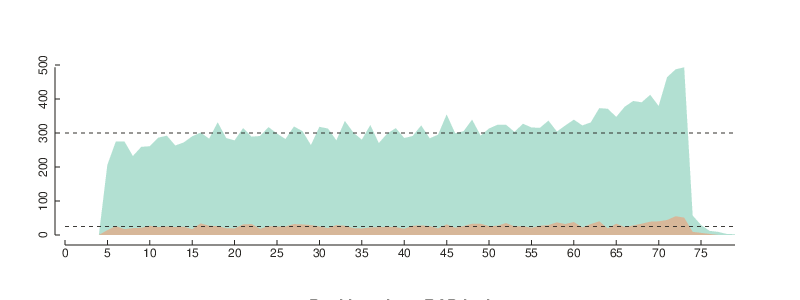

In [26]:
canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
toyplot.html.render(canvas, 'snp_positions.html')

## show fig
canvas
#axes

### Possible reasons for the uptick in SNPs towards the end of reads: 
+ Sequencing error rate increases along the length of reads
+ Poor muscle alignment at the end of reads

I think the more likely explanation is that poor alignment towards the end of reads is causing the excess SNPs for two reasons. First, if it was sequencing errors than we would expect an excess of autapomorphies at the end of reads equally or more so than we observe synapomorphies, but that is not the case. And second, increasing the minimum depth does fix the problem. 

### Apply a more stringent edge filter
Positive values of the edge filter 

In [ ]:
## make a new branch of cyatho-d6-min4
data5 = data1.branch('cyatho-d6-min4-trim')

## edge filter order is (R1left, R1right, R2left, R2right)
## we set the R1right to -10, which trims 10 bases from the right side
data5.set_params('edge_filter', ("4, -10, 4, 4"))

## run step7 to fill new data base w/ filters
data5.run('7', force=True)

In [169]:
data5 = ip.load_json("~/Downloads/pedicularis/cyatho-d12-min4")

  loading Assembly: cyatho-d12-min4
  from saved path: ~/Downloads/pedicularis/cyatho-d12-min4.json


In [170]:
## filter the snps
fsnps = filter_snps(data5)

## trim non-data 
maxend = np.where(fsnps[:, :, :].sum(axis=0).sum(axis=1) != 0)[0].max()

## all variables (including autapomorphies)
distvar = np.sum(fsnps[:, :maxend+1, 0].astype(np.int), axis=0)
print(distvar)

## synapomorphies (just pis)
distpis = fsnps[:, :maxend+1, 1].sum(axis=0)
print(distpis)

## how long is the longest seq
print 'maxlen = ', maxend

prefilter cyatho-d12-min4
shape (54652, 150, 2) = (nloci, locus_len, [var,pis])
total vars = 158199
postfilter cyatho-d12-min4
shape (29859, 150, 2) = (nloci, locus_len, [var,pis])
total vars = 86868
[   0    0    0    0    0  922 1050 1022  982 1066 1108 1018 1090 1089 1104
 1134 1082 1085 1182 1131 1133 1134 1127 1119 1157 1168 1133 1150 1174 1082
 1162 1161 1084 1178 1186 1146 1128 1151 1149 1177 1218 1142 1196 1146 1172
 1226 1211 1167 1215 1181 1239 1244 1188 1180 1217 1242 1222 1297 1321 1245
 1313 1337 1322 1404 1436 1507 1519 1603 1624 1727 1871 1878 2041 2199  377
  182  132   78   41   24   16    4]
[   0    0    0    0    0  428  503  479  484  544  535  522  608  554  523
  556  595  588  628  535  535  584  579  576  576  541  551  629  555  597
  584  602  543  596  585  540  584  591  616  601  578  588  597  597  553
  591  599  606  631  580  617  623  625  594  646  593  606  672  599  673
  657  659  675  717  721  686  800  776  844  957  954 1024 1120 1182  198
  1

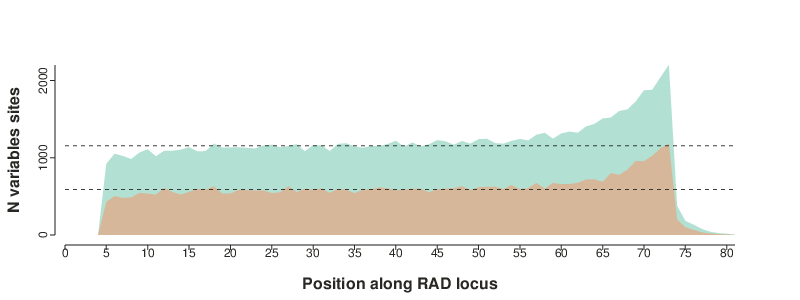

In [171]:
SNP_position_plot(distvar, distpis)

### Why the right side but not the left?
I found early on that leaving the cut site attached to the left side of reads improved assemblies by acting as an achor, which then allowed gap openings to arise in the early parts of the read but not to be treated differently, i.e., as terminal gap openings. For some reason it didn't occur to me to similarly anchor the right side of reads. Let's see what happens if I had an invariant anchor to the right side of reads. 

Another point to note, though I don't show the results here, this increase in variation along the length of reads is not observed in simulated data, suggesting it is inherent to real data. 


In [15]:
simdata = ip.load_json("~/Documents/ipyrad/tests/cli/cli.json")

## filter the snps
fsnps = filter_snps(simdata)

## trim non-data 
maxend = np.where(fsnps[:, :, :].sum(axis=0).sum(axis=1) != 0)[0].max()

## all variables (including autapomorphies)
distvar = np.sum(fsnps[:, :maxend+1, 0].astype(np.int), axis=0)

## synapomorphies (just pis)
distpis = fsnps[:, :maxend+1, 1].sum(axis=0)

SNP_position_plot(distvar, distpis)

  loading Assembly: cli
  from saved path: ~/Documents/ipyrad/tests/cli/cli.json


(<toyplot.canvas.Canvas at 0x7f7b1feb3dd0>,
 <toyplot.axes.Cartesian at 0x7f7b1feb3b90>)

<polygon points="65.0,235.0 72.127659574468083,235.0 79.255319148936167,235.0 86.38297872340425,235.0 93.510638297872347,235.0 100.63829787234042,235.0 107.7659574468085,235.0 114.89361702127658,235.0 122.02127659574468,235.0 129.14893617021278,235.0 136.27659574468083,235.0 143.40425531914894,235.0 150.531914893617,235.0 157.65957446808511,235.0 164.78723404255319,235.0 171.91489361702128,235.0 179.04255319148936,235.0 186.17021276595747,235.0 193.29787234042556,235.0 200.42553191489361,235.0 207.55319148936169,235.0 214.68085106382981,235.0 221.80851063829789,235.0 228.93617021276594,235.0 236.06382978723403,235.0 243.19148936170211,235.0 250.31914893617019,235.0 257.44680851063828,235.0 264.57446808510639,235.0 271.70212765957444,235.0 278.82978723404256,235.0 285.95744680851061,235.0 293.08510638297872,235.0 300.21276595744678,235.0 307.34042553191495,235.0 314.468085106383,235.0 321.59574468085106,235.0 328.72340425531917,235.0 335.85106382978722,235.0 342.97872340425528,235.0 350.10638297872339,235.0 357.2340425531915,235.0 364.36170212765956,235.0 371.48936170212767,235.0 378.61702127659578,235.0 385.74468085106389,235.0 392.87234042553189,235.0 400.0,235.0 407.12765957446805,235.0 414.25531914893617,235.0 421.38297872340422,235.0 428.51063829787233,235.0 435.63829787234044,235.0 442.7659574468085,235.0 449.89361702127661,235.0 457.02127659574472,235.0 464.14893617021272,235.0 471.27659574468089,235.0 478.40425531914894,235.0 485.531914893617,235.0 492.65957446808511,235.0 499.78723404255322,235.0 506.91489361702128,235.0 514.04255319148945,235.0 521.17021276595744,235.0 528.29787234042556,235.0 535.42553191489355,235.0 542.55319148936167,235.0 549.68085106382989,235.0 556.80851063829789,235.0 563.936170212766,235.0 571.063829787234,235.0 578.19148936170211,235.0 585.31914893617011,235.0 592.44680851063833,235.0 599.57446808510645,235.0 606.70212765957444,235.0 613.82978723404267,235.0 620.95744680851055,235.0 628.08510638297878,235.0 635.21276595744678,235.0 642.34042553191489,235.0 649.468085106383,235.0 656.59574468085111,235.0 663.72340425531922,235.0 670.85106382978722,235.0 677.97872340425533,235.0 685.10638297872333,235.0 692.23404255319156,235.0 699.36170212765956,235.0 706.48936170212778,235.0 713.61702127659566,235.0 720.74468085106378,235.0 727.87234042553189,235.0 735.0,235.0 735.0,229.6875 727.87234042553189,235.0 720.74468085106378,112.8125 713.61702127659566,160.625 706.48936170212778,176.5625 699.36170212765956,150.0 692.23404255319156,160.625 685.10638297872333,165.9375 677.97872340425533,91.5625 670.85106382978722,144.6875 663.72340425531922,123.4375 656.59574468085111,91.5625 649.468085106383,144.6875 642.34042553191489,134.0625 635.21276595744678,134.0625 628.08510638297878,139.375 620.95744680851055,139.375 613.82978723404267,139.375 606.70212765957444,107.5 599.57446808510645,96.875 592.44680851063833,123.4375 585.31914893617011,155.3125 578.19148936170211,160.625 571.063829787234,118.125 563.936170212766,123.4375 556.80851063829789,128.75 549.68085106382989,123.4375 542.55319148936167,128.75 535.42553191489355,107.5 528.29787234042556,134.0625 521.17021276595744,118.125 514.04255319148945,139.375 506.91489361702128,139.375 499.78723404255322,107.5 492.65957446808511,128.75 485.531914893617,112.8125 478.40425531914894,75.625 471.27659574468089,123.4375 464.14893617021272,96.875 457.02127659574472,134.0625 449.89361702127661,112.8125 442.7659574468085,160.625 435.63829787234044,123.4375 428.51063829787233,155.3125 421.38297872340422,139.375 414.25531914893617,176.5625 407.12765957446805,96.875 400.0,139.375 392.87234042553189,107.5 385.74468085106389,123.4375 378.61702127659578,128.75 371.48936170212767,144.6875 364.36170212765956,112.8125 357.2340425531915,150.0 350.10638297872339,86.25 342.97872340425528,91.5625 335.85106382978722,123.4375 328.72340425531917,150.0 321.59574468085106,91.5625 314.468085106383,134.0625 307.34042553191495,176.5625 300.21276595744678,123.4375 293.08510638297872,96.875 

### Results when I add a right-side anchor
I now add a five base anchor just before muscle alignment, and then strip it off again after aligning. I have an added check to make sure that the anchor is definitely not left on the read in case muscle did try to stick an opening into the anchor. 

In [172]:
## import the new version of ipyrad w/ this update.
import ipyrad as ip
print ip.__version__

0.2.1
